In [54]:
import glob
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

In [55]:
# create a string describing station for directories/filenames
def station_string(sta):
    loc_str = "".join(
        [
            c if c != " " else "_"
            for c in [c for c in sta["name"].lower() if c not in [",", "."]]
        ]
    )

    sta_str = loc_str + "_" + str(sta["noaa id"])

    return sta_str

In [56]:
def thrsh_exprmnts_figs(
    ax, sta, Nhr, trace, rt, x_nrm, tru, x, y, show_leg=True
):

    sta_str = station_string(sta)

    # -----------------------------------------------------------------------

    # gaussian CDF (GCDF)
    def gcdf(x0, loc0, sc0):
        return 0.5 * (1 + sp.special.erf((x0 - loc0) / (sc0 * np.sqrt(2))))

    def logistic(x0, rt0, z0):
        # rt is the slope of transition, x0 is the location
        return 1 / (1 + np.exp(-rt0 * (x0 - z0)))

    # -----------------------------------------------------------------------

    mu = np.zeros([tru["x"].size, trace["mu_loc1"].size])
    N_xd = np.zeros([tru["x"].size, trace["mu_loc1"].size])
    for k in range(trace["mu_loc1"].size):

        mu1 = logistic(tru["x"], -rt, trace["z"][k]) * gcdf(
            tru["x"], trace["mu_loc1"][k], trace["mu_sc1"][k]
        )
        mu2 = logistic(tru["x"], rt, trace["z"][k]) * gcdf(
            tru["x"], trace["mu_loc2"][k], trace["mu_sc2"][k]
        )
        mu[:, k] = mu1 + mu2

        v = trace["nu"][k] * mu[:, k] * (1 - mu[:, k])

        z = v > 1e-15  # don't divide by zero
        z_min = ~z & (mu[:, k] < 0.5)
        z_max = ~z & (mu[:, k] > 0.5)
        mu_z = mu[z, k]
        v_z = v[z]

        kappa = mu_z * (1 - mu_z) / v_z - 1
        a = mu_z * kappa
        b = (1 - mu_z) * kappa

        p_z = stats.beta.rvs(a, b)

        N_xd[z, k] = stats.binom.rvs(Nhr, p_z)
        N_xd[z_min, :] = 0
        N_xd[z_max, :] = Nhr

    mu_ci05 = np.percentile(mu, 5, axis=1)
    mu_ci95 = np.percentile(mu, 95, axis=1)

    N_xd_ci05 = np.percentile(N_xd, 5, axis=1)
    N_xd_ci95 = np.percentile(N_xd, 95, axis=1)

    e99_smpl = x_nrm[0] + (x_nrm[1] - x_nrm[0]) * x
    e99_tru = x_nrm[0] + (x_nrm[1] - x_nrm[0]) * tru["x"]

    # -----------------------------------------------------------------------

    msmtch = np.std(tru["mu"] - Nhr * np.percentile(mu, 50, axis=1))

    # -----------------------------------------------------------------------

    col = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    ax.fill_between(
        e99_tru,
        N_xd_ci05,
        N_xd_ci95,
        color=col[1],
        alpha=0.5,
        lw=0,
        label="Modeled distribution (90% CI)",
    )
    ax.fill_between(
        e99_tru,
        Nhr * mu_ci05,
        Nhr * mu_ci95,
        color=col[3],
        alpha=1.0,
        lw=0,
        label="Modeled average (90% CI)",
    )
    ax.plot(e99_smpl, y, ".", color="gray", label="Observed montly counts")
    ax.plot(e99_tru, tru["mu"], "--k", lw=2, label="Average observed count")
    ax.set_xlim([-50, 150])
    ax.set_title(sta["name"] + " (January)")
    ax.set_xlabel("$\Delta_{99}$ (cm)")
    ax.set_ylabel("HTF days (monthly counts)")
    if show_leg:
        ax.legend()

In [57]:
fname = "../stations.pickle"
stations = pd.read_pickle(fname)

# select two cases to show
cases = [
    {
        "sta": stations.loc[stations["noaa id"] == 1612340].iloc[0], # honolulu
        "mo": 1,
        "tod": [0, 23],
    },
    {
        "sta": stations.loc[stations["noaa id"] == 8443970].iloc[0], # boston
        "mo": 1,
        "tod": [0, 23],
    },
]

/Users/Phil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


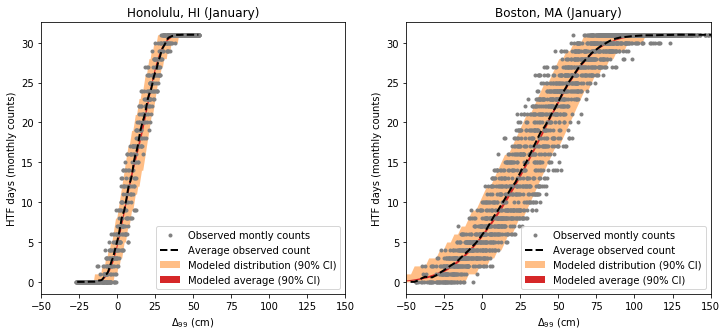

In [58]:
fig = plt.figure(num="bayes_betaBinom_mu", figsize=[12, 5])
fig.clf()

for n, cs in enumerate(cases):

    sta_str = station_string(cs["sta"])

    sta_path = "../Output/pickle/" + sta_str + "/"
    mo_str = "mo" + "{:0>2}".format(cs["mo"])
    tod_str = (
        "h" + "{:0>2}".format(cs["tod"][0]) + "{:0>2}".format(cs["tod"][1])
    )
    exp_str = mo_str + "_" + tod_str
    fname = sta_path + exp_str + "/bbmodel.pickle"

    with open(fname, "rb") as f:
        p = pickle.load(f)
    trace, x_nrm, tru, x, y, Ndy, rt = (
        p["trace"],
        p["x_nrm"],
        p["true"],
        p["xy"]["x"],
        p["xy"]["y"],
        p["Ndy"],
        p["rt"],
    )

    ax = fig.add_subplot(1, 2, n + 1)
    msmtch = thrsh_exprmnts_figs(
        ax, cs["sta"], Ndy, trace, rt, x_nrm, tru, x, y
    )

fig.show()

fname = "./fig_methods_bb_fit.pdf"
fig.savefig(fname)